# Second order stochastic methods for CryoEM -- OASIS

In [1]:
%load_ext autoreload
%autoreload 2
import site
import sys
import time
import pickle
site.addsitedir('..')
from jax.config import config

config.update("jax_enable_x64", True)

In [2]:
import jax
import mrcfile
from jax.scipy.special import gammaln
from jax import random
from tqdm import tqdm 

import numpy as np
import jax.numpy as jnp
from  matplotlib import pyplot as plt
from src.utils import *
from src.projection import *
from src.interpolate import *
from src.jaxops import *
from src.algorithm import sgd, get_sgd_vol_ops, get_cg_vol_ops
from src.algorithm import conjugate_gradient as cg
from src.algorithm import oasis, oasis_adaptive
from src.datasets import *
from src.noise import estimate_noise, average_radially, estimate_noise_radial
from src.preprocess import *
from src.fsc import calc_fsc

plt.rcParams["figure.figsize"]=6,6

In [3]:
data_dir = "/gpfs/gibbs/pi/lederman/dge5/CrossValidationCryodrgnSet/"
star_file = "particles_crossvalidation_train_1.star"

params0, imgs0 = load_data(data_dir, star_file, load_imgs = True, fourier = False)

/home/bt387/project/2021_CryoEMSolver7/external/pyem/pyem/star.py:531: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df[UCSF.IMAGE_INDEX], df[UCSF.IMAGE_PATH] = \
/home/bt387/project/2021_CryoEMSolver7/external/pyem/pyem/star.py:539: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df[UCSF.IMAGE_ORIGINAL_INDEX], df[UCSF.IMAGE_ORIGINAL_PATH] = \


load_data: number of partcles: 105519
load_data: data loaded, time:  76.09 sec.


In [4]:
# Extract a subset with fixed seed key so that we always get the same subset.
# Larger sets must be supersets of the smaller sets respectively.

N0 = imgs0.shape[0]
nx0 = imgs0.shape[1]

subset_seed = 60
subset_key = random.PRNGKey(subset_seed)
idx_full = random.permutation(subset_key, N0)

print(subset_key)
print(idx_full[:10])

[ 0 60]
[ 18720  60093  53249 102196  43608  18973  24325  65695  39526  50914]


In [5]:
out_dir = out_dir = '../data/out_dev/'

nx_crop = 64 #128 #192 #64 #8 #192 # 128 # 64
N = 10000 #50000 #10000 #200 #104000 #80000 # 20000

idx = idx_full[:N]

In [6]:
processed_data = preprocess(imgs0, params0, nx_crop = nx_crop, idx = idx)

imgs_f = processed_data["imgs_f"]
angles = processed_data["angles"]
shifts = processed_data["shifts"]
ctf_params = processed_data["ctf_params"]

imgs0.shape = (105519, 320, 320)
pixel_size0.shape = (105519,)
angles0.shape = (105519, 3)
shifts0.shape = (105519, 2)
ctf_params0.shape = (105519, 9)
N0 = 105519
idx provided
N = 10000
Taking FFT of the images:
Batch 1/10  2.77 sec.
Batch 2/10  2.76 sec.
Batch 3/10  2.76 sec.
Batch 4/10  2.77 sec.
Batch 5/10  2.77 sec.
Batch 6/10  2.76 sec.
Batch 7/10  2.77 sec.
Batch 8/10  2.77 sec.
Batch 9/10  2.79 sec.
Batch 10/10  2.77 sec.
FFT done. Time:  34.20 sec.
x_grid = [2.38549618e-03 3.20000000e+02]
new x_grid = [2.38549618e-03 6.40000000e+01]
Vectorised imgs_f.shape = (10000, 4096)
Mask radius = 0.0739503816793893
Noise free, setting sigma_noise = 1


In [7]:
# Assuming these variables are the same for all images

pixel_size = processed_data["pixel_size"]
nx = processed_data["nx"]
mask = processed_data["mask"]
sigma_noise = processed_data["sigma_noise"]
x_grid = processed_data["x_grid"]
N = imgs_f.shape[0]

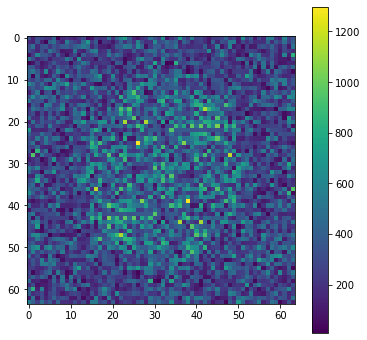

In [8]:
plt.imshow(jnp.fft.fftshift(jnp.abs(imgs_f[15].reshape([nx_crop,nx_crop]))));plt.colorbar()

In [9]:
#del(imgs0)

### Only volume reconstruction for now - SGD vs OASIS

In [10]:
# Apply mask to images

apply_mask = True

if apply_mask:
    mask2d = mask[0].reshape(-1)
    imgs_f = imgs_f * mask2d
else:
    mask = jnp.ones(mask.shape)

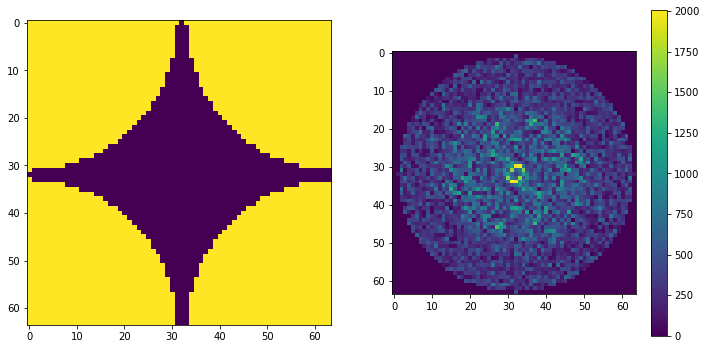

In [11]:
plt.rcParams["figure.figsize"]=12,6

plt.subplot(1,2,1)
plt.imshow(mask[0])

plt.subplot(1,2,2)
plt.imshow(jnp.fft.fftshift(jnp.abs(imgs_f[123].reshape([nx_crop,nx_crop]))));plt.colorbar()

plt.rcParams["figure.figsize"]=6,6

Use the same datasets, loss, grad, hvp, x0, D0 for SGD, OASIS (and CG)

In [12]:
alpha =  1e-9 #1e-5 #1e-9 #1e-9 # 1e-5
interp_method = "tri"

slice_obj = Slice(x_grid, mask = mask, interp_method = interp_method)
loss_obj = Loss(slice_obj, alpha = alpha)
gradv_obj = GradV(loss_obj)


grad_func, loss_func, hvp_func = get_sgd_vol_ops(gradv_obj, loss_obj, angles, shifts, ctf_params, imgs_f, sigma_noise)


In [49]:
n_epochs = 20 #3 #2000 * 4 
batch_sz = 1000
n_batch = N // batch_sz

zD0z = np.zeros([nx,nx,nx])

#zD0z = [] 

key = random.PRNGKey(62)
key, subkey = random.split(key)
x0 = random.normal(subkey, [nx,nx,nx], dtype=jnp.complex128)

for i in tqdm(range(n_epochs)):
    key, subkey = random.split(key)
    idx_batches = np.array_split(random.permutation(subkey, N), n_batch)
        
    for idx in idx_batches:
        key, subkey = random.split(key)

        z = random.rademacher(subkey, [nx,nx,nx], dtype=x0.dtype)

        zD0z += z * hvp_func(x0, z, np.array(idx))

        # Any more memory efficient way of doing this? The kernel dies :(
        
        # For some reason, passing idx without np.array doesn't work (it is
        # considered to be tuple
        #zD0z.append(z * hvp_func(x0, z, np.array(idx)))

zD0z = np.array(zD0z)
        
#D0 = np.mean(zD0z, axis = 0)

D0 = zD0z / (n_epochs * n_batch)

100%|██████████| 20/20 [00:16<00:00,  1.21it/s]


In [14]:
# Compute the sums term by term to have an idea of convergence
compute_separate_terms = False

if compute_separate_terms:
    D0est = [zD0z[0]]
    for i in tqdm(range(1, len(zD01z))):
        D0est.append(D0est[-1] + zD0z[i])

        #D0est[i] = D0est[i] / (i+1)

    D0est = np.array([ Di / (i+1) for i, Di in enumerate(D01est)])

In [15]:
if compute_separate_terms:
    D0norm = []
    for i in tqdm(range(len(D01est))):
        D0norm.append(jnp.linalg.norm(D0est[i].reshape(-1), 2))

In [16]:
if compute_separate_terms:
    assert(jnp.max(jnp.abs(D0est[-1] - D0)) == 0)

9.999999999999999e-10
0.022755424094874372
22755424.094874375


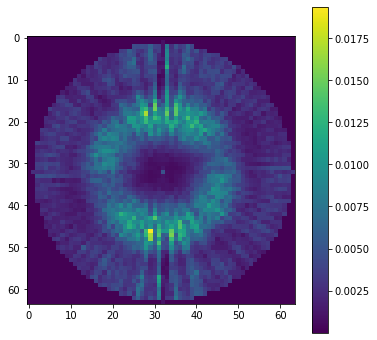

In [17]:
plt.imshow(jnp.fft.fftshift(jnp.abs(D0[0,:,:]))); plt.colorbar()
print(jnp.min(jnp.abs(D0)))
print(jnp.max(jnp.abs(D0)))
print(jnp.max(jnp.abs(D0))/jnp.min(jnp.abs(D0)))

In [18]:
# Compute the Hessian diagonals exactly (valid for NN interpolation) - do it in batches

compute_hess_diag = False

if compute_hess_diag:
    batch_sz = 10
    n_batch = N // batch_sz
    idx_batches = np.array_split(np.arange(N), n_batch)
    ones = jnp.ones(x0.shape, dtype=jnp.complex128)

    D = np.zeros([nx,nx,nx], dtype=np.complex128)
    for idx in idx_batches:
        D += hvp_func1(x0, ones, idx)

    D = jnp.array(D/n_batch)

In [19]:
if compute_hess_diag:
    plt.imshow(jnp.fft.fftshift(jnp.abs(D0[0,:,:]))); plt.colorbar()
    print(jnp.min(jnp.abs(D)))
    print(jnp.max(jnp.abs(D)))
    print(jnp.max(jnp.abs(D))/jnp.min(jnp.abs(D)))

In [20]:
if compute_hess_diag:
    err1 = jnp.max(jnp.abs(D-D0)/jnp.max(jnp.abs(D)))
    print(f"Error D = {err1}")

In [21]:
if compute_separate_terms:
    err_D = [ jnp.max(jnp.abs(D - Di))/jnp.max(jnp.abs(D)) for Di in D0est ]

    #err_D = [ jnp.max(jnp.abs(D - Di)) for Di in D0est ]
    
    plt.subplot(1,2,1)
    plt.semilogy(err_D)
    
    plt.subplot(1,2,2)
    errr = jnp.abs(jnp.array(D0norm))
    plt.semilogy(errr)

#### Sanity check that the Hessian is indeed diagonal for NN interpolation and that I'm computing it correctly

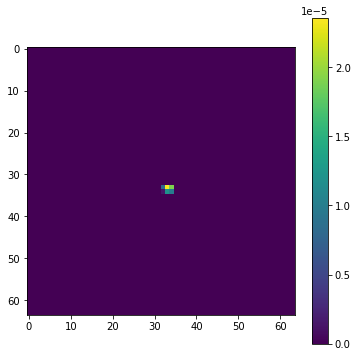

In [22]:
ei = jnp.zeros([nx,nx,nx], dtype = jnp.complex128)
ei = ei.at[0,2,1].set(1)
hvp = hvp_func(x0, ei, np.array([23, 1, 0, 6]))
plt.imshow(jnp.fft.fftshift(jnp.abs(hvp[0,:,:]))); plt.colorbar()

In [23]:
if interp_method == "nn":
    print("Checking")
    assert(jnp.abs(hvp[0,2,1] - jnp.sum(hvp)) == 0)

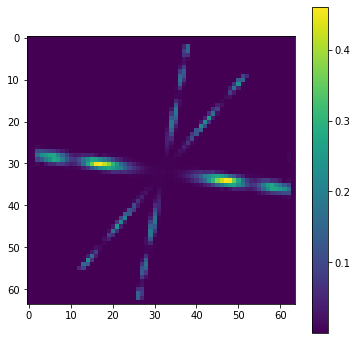

In [24]:
ones = jnp.ones(x0.shape, dtype=jnp.complex128)
hvp_diag = hvp_func(x0, ones, np.array([23, 1, 0, 6]))
plt.imshow(jnp.fft.fftshift(jnp.abs(hvp_diag[0,:,:]))); plt.colorbar()

In [25]:
if interp_method == "nn":
    print("Checking")
    assert(jnp.abs(hvp[0,2,1] - hvp_diag[0,2,1]) == 0)

### Compute full Hessian (only for small operators)

In [26]:
compute_full_hessian = False

In [27]:
if compute_full_hessian:
    print("Computing Hessian...", end="")
    H = jax.hessian(lambda x : loss_func(x, np.arange(10)))(jnp.real(x0))
    print("done.")
    H = H.reshape([nx**3, nx**3])
    
    print("Computing Hessian inverse...", end="")
    Hinv = jnp.linalg.inv(H)
    print("done.")

    

In [28]:
#plt.spy(H1)

In [29]:
#plt.spy(H1inv)

In [30]:
#H1log = jnp.log(H1)
#H1log = jnp.abs(H1log.at[H1log == -jnp.inf].set(0))

#H1log = H1log.at[H1log == jnp.inf].set(0)
#plt.spy(H1log)

In [31]:
#plt.spy(H1log)

In [32]:
#H1log[0]

In [33]:
if compute_full_hessian:
    plt.rcParams["figure.figsize"]=24,24

    plt.imshow((jnp.abs(Hinv)))
    plt.colorbar()

In [34]:
if compute_full_hessian:
    plt.imshow((H[:nx*3,:nx*3])); plt.colorbar()


In [35]:
if compute_full_hessian:

    plt.rcParams["figure.figsize"]=12,12

    plt.imshow((Hlog[nx**2:2*nx**2,nx**2:2*nx**2])); plt.colorbar()

    plt.rcParams["figure.figsize"]=6,6

In [36]:
if compute_full_hessian:
    plt.rcParams["figure.figsize"]=12,12

    plt.imshow((Hlog[:2*nx , :nx*2])); plt.colorbar()
    #plt.imshow((Hki)); #plt.colorbar()

    plt.rcParams["figure.figsize"]=6,6

### Inititial points

In [37]:
# Use a fixed seed and the same size (e.g. 320) every time we generate x01 and x02
# and only then crop to the intended size, to ensure that we always generate the same starting 
# points no matter the dimensions.

key = random.PRNGKey(64)
key, subkey = random.split(key)

x0 = random.normal(subkey, [320,320,320], dtype = jnp.complex128)

x0 = x0[:nx, :nx, :nx]

print(x0[:2,:2,:2])

[[[-0.37767704-0.82574715j  0.56289944-1.94969685j]
  [-0.7794795 -1.39959255j -0.18751101-0.50461654j]]

 [[-0.28829522+0.87826051j  0.22657018-0.1993285j ]
  [ 0.459454  +0.70868103j -0.38079872+0.73749644j]]]


#### SGD no precon

In [38]:
N_epochs = 5
batch_size = 1000
step_size = 10 #1e-1 # 1e1 #1e1 #1e1 #1e1 #1e-4 #1e-1 #1e-5 #1e-2 #1000000 # 1e-3
c = 0.9

# Step sizes (empirically found, i.e. the largest that doesn't lead to loss exploding): 

#### Tri interpolation, lam=1e-9

# 10k imgs, 64px:
#   no precon: 1e1
#   precon: 1e-1

# 40k imgs, 128px:
#  no precon: 1e1
#  precon: 1e-1 (with D1, D2 computed as for NN -- similar to OASIS)


### NN interpolation, lam=1e-9

# 10k imgs, 64px:
#   no precon: 1e1
#   precon: 1e-1

# 40k imgs, 128px:
#   no precon: 1e0
#   precon: 1e-2


### NN interpolation, lam=1e-12

# 40k imgs, 128px:
#   no precon: 1e1
#   precon: 

# 52k imgs, 192px:
#   no precon: 1e0
#   precon: 

In [39]:
P = None

t0 = time.time()

v_rec, loss_rec, grad_rec = sgd(grad_func, loss_func, N, x0, step_size, N_epochs, batch_size, P = P, adaptive_step_size = True, c = c, verbose=True, iter_display=1)

print(f"Total time: {time.time()-t0 : .2f} seconds")

Epoch 1/5 

100%|██████████| 10/10 [00:11<00:00,  1.13s/it, grad=1.456e+01, loss=3.103e+08]


  |Grad| = 1.967e+01
  Loss = 3.127e+08
  alpha = 15.479341055999992
Epoch 2/5 

100%|██████████| 10/10 [00:02<00:00,  3.89it/s, grad=1.077e+01, loss=3.115e+08]


  |Grad| = 1.187e+01
  Loss = 3.107e+08
  alpha = 11.98049997639835
Epoch 3/5 

100%|██████████| 10/10 [00:02<00:00,  4.01it/s, grad=7.016e+00, loss=3.087e+08]


  |Grad| = 8.485e+00
  Loss = 3.100e+08
  alpha = 18.545024515606997
Epoch 4/5 

100%|██████████| 10/10 [00:02<00:00,  3.86it/s, grad=7.114e+00, loss=3.095e+08]


  |Grad| = 7.088e+00
  Loss = 3.096e+08
  alpha = 14.353237968448093
Epoch 5/5 

100%|██████████| 10/10 [00:02<00:00,  3.90it/s, grad=6.972e+00, loss=3.085e+08]


  |Grad| = 7.060e+00
  Loss = 3.094e+08
  alpha = 11.108933288576827
Total time:  26.04 seconds


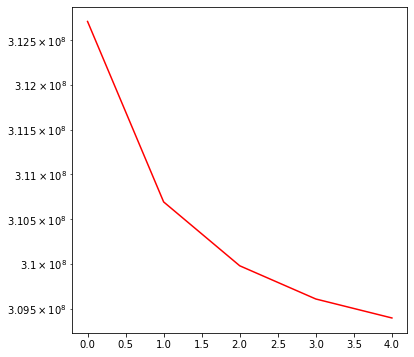

In [40]:
plt.semilogy(loss_rec, 'r')

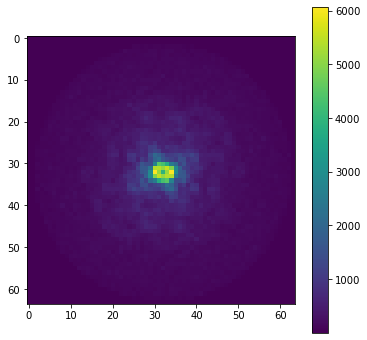

In [114]:
plt.rcParams["figure.figsize"]=6,6

mip_z(np.fft.fftshift(np.abs(v_rec))); plt.colorbar()

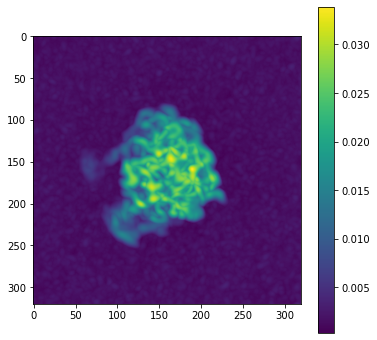

In [42]:
v_rec_l, _ = rescale_larger_grid(v_rec, x_grid, nx0)
vr_sgd = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_rec_l)))

mip_z(vr_sgd)
plt.colorbar()


In [43]:
with mrcfile.new(f"{out_dir}/v_rec_sgd.mrc", overwrite=True) as mrc:
    mrc.set_data(vr_sgd.astype(np.float32))

In [44]:
#res, fsc_sgd, shell_points = calc_fsc(v_rec1, v_rec2, [1, nx_crop])
#res_angs = nx0 * pixel_size[0]/res
#plt.semilogx(res_angs, fsc_sgd)
#plt.gca().invert_xaxis()
#plt.title("FSC")

### SGD preconditioned + adaptive

In [45]:
N_epochs = 5
batch_size = 1000
step_size = 10
c = 0.9

In [50]:
# for Tri + big data, I couldn't make the preconditioned work at all. Probably bad preconditioner??

P = 1/D0

t0 = time.time()

v_p_rec, loss_p_rec, grad_p_rec = sgd(grad_func, loss_func, N, x0, step_size, N_epochs, batch_size, P = P, adaptive_step_size = True, c = c, verbose=True, iter_display=1)

print(f"Total time: {time.time()-t0 : .2f} seconds")

Epoch 1/5 

100%|██████████| 10/10 [00:03<00:00,  2.82it/s, grad=1.031e+01, loss=3.129e+08]


  |Grad| = 1.690e+01
  Loss = 3.113e+08
  alpha = 0.007558271999999996
Epoch 2/5 

100%|██████████| 10/10 [00:02<00:00,  4.17it/s, grad=9.451e+00, loss=3.104e+08]


  |Grad| = 1.103e+01
  Loss = 3.099e+08
  alpha = 0.04679882803280606
Epoch 3/5 

100%|██████████| 10/10 [00:02<00:00,  3.76it/s, grad=7.658e+00, loss=3.114e+08]


  |Grad| = 8.320e+00
  Loss = 3.096e+08
  alpha = 0.036220751007044916
Epoch 4/5 

100%|██████████| 10/10 [00:02<00:00,  3.73it/s, grad=7.289e+00, loss=3.089e+08]


  |Grad| = 6.947e+00
  Loss = 3.093e+08
  alpha = 0.028033667907125182
Epoch 5/5 

100%|██████████| 10/10 [00:02<00:00,  3.65it/s, grad=6.325e+00, loss=3.159e+08]


  |Grad| = 6.369e+00
  Loss = 3.093e+08
  alpha = 0.010848567664625807
Total time:  17.73 seconds


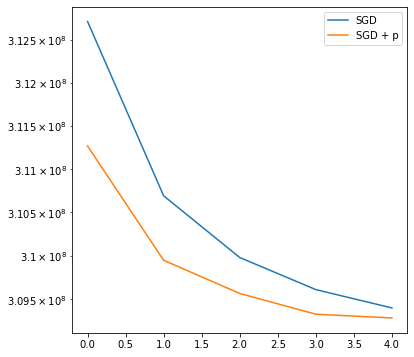

In [51]:
plt.semilogy(loss_rec)
plt.semilogy(loss_p_rec)
plt.legend(['SGD', 'SGD + p'])

#### L-BFGS

In [52]:
from jaxopt import LBFGS

In [219]:
N_batch = N/batch_size
idx_batches = np.array_split(np.arange(N), N_batch)



@jax.jit
def loss_full_func(x): 
    
    loss_b = []
    grad_b = []
    for idx in idx_batches:
        loss_b.append(loss_func(x, idx))
        grad_b.append(grad_func(x, idx))
        
    loss_full = jnp.mean(jnp.array(loss_b), axis = 0)    
    grad_full = jnp.mean(jnp.array(grad_b), axis = 0)
    
    return loss_full, jnp.conj(grad_full)
    
    
    

In [220]:
#loss_full_lam = lambda x : loss_func(x, range(N))

In [223]:
vv, gg = loss_full_func(x0)

In [224]:
gg.dtype

dtype('complex128')

In [225]:
lbfgs = LBFGS(loss_full_func, value_and_grad = True, linesearch = 'backtracking', maxiter=5, verbose=True)


In [234]:
sol = lbfgs.run(v_p_rec)
v_lbfgs = sol.params

error: (5.6516002979417825-0.13103635085737517j)
error: (5.645058834324148-0.13028463092718412j)
error: (5.6440396009016345-0.130290001050844j)
error: (5.644043084894905-0.13028535357743223j)


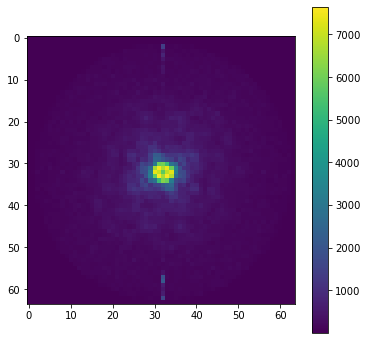

In [235]:
mip_z(np.fft.fftshift(np.abs(v_lbfgs))); plt.colorbar()

In [236]:
jnp.max(jnp.abs(jnp.imag(jnp.fft.fftshift(jnp.fft.ifftn(v_p_rec)))))

DeviceArray(0.03695346, dtype=float64)

In [237]:
jnp.max(jnp.abs(jnp.imag(jnp.fft.fftshift(jnp.fft.ifftn(v_rec)))))

DeviceArray(0.00523459, dtype=float64)

In [238]:
jnp.max(jnp.abs(jnp.imag(jnp.fft.fftshift(jnp.fft.ifftn(v_lbfgs)))))

DeviceArray(0.03694062, dtype=float64)

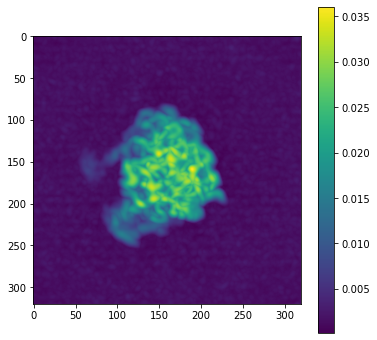

In [239]:
v_lbfgs_l, _ = rescale_larger_grid(v_lbfgs, x_grid, nx0)
vr_lbfgs = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_lbfgs_l)))

mip_z(vr_lbfgs)
plt.colorbar()

In [282]:
loss_bfgs = loss_func(v_lbfgs, jnp.arange(N))


In [240]:
print(loss_func(v_rec, jnp.arange(N)))
print(loss_func(v_p_rec, jnp.arange(N)))
print(loss_func(v_lbfgs, jnp.arange(N)))


309400273.285274
309284982.12176573
309284122.7070313


In [241]:
with mrcfile.new(f"{out_dir}/v_rec_lbfgs.mrc", overwrite=True) as mrc:
    mrc.set_data(vr_lbfgs.astype(np.float32))

#### OASIS

### Next: try a pixel-wise beta that decreases with the radius x 0.5 or smth like that

In [242]:
bb = np.ones(x0.shape)
#bb[32:96,32:96,32:96] = 0.8
bb = jnp.fft.ifftshift(bb)

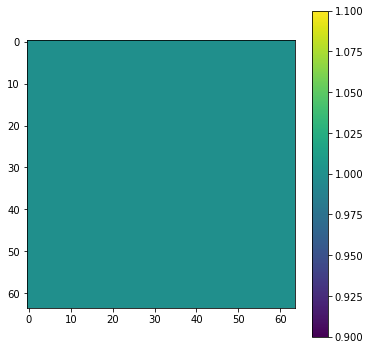

In [243]:
plt.imshow(bb[0])
plt.colorbar()

In [244]:
N_epoch = 5
beta2 = bb * 0.5
eta0 = 10 # 1e0 #5e-2 #1e-2 # 1e-3 #1e-5 #0.0001 #0.1/0.001/0.01/0.15
batch_size = 1000
alpha = 0 #1e-7 
c = 0.9


#### Tri interpolation, lam=1e-9

# 10k imgs, 64px:
#  1e-1 (*0.5 or not depending on beta2)

# 40k imgs, 128px:
#  1e-2 

# On the big dataset, D1 D2 as calculated for NN interpolation seem better than the ones obtained 
# using Hutchinson's method with 20 epochs.


#### NN interpolation, no sigma_noise, lam=1e-9

# 10k imgs, 64px:
#   1e-1

# 40k imgs, 128px:
#   1e-2

# 52k imgs, 192px: (lam=1e-7)
#   1e-2 

In [245]:
key, subkey = random.split(key)

t0 = time.time()

v_rec_o, loss_o = oasis(subkey, loss_func, grad_func, hvp_func, x0, eta0, jnp.ones(x0.shape), beta2, alpha, N_epoch, batch_size = batch_size, N = N, adaptive_step_size = True, c = c, iter_display = 1)

print(f"Total time: {time.time()-t0 : .2f} seconds")

Epoch 1/5


100%|██████████| 10/10 [00:11<00:00,  1.17s/it, loss=3.116e+08]


  Loss =  3.125e+08
  eta = 15.479341055999992
Epoch 2/5


100%|██████████| 10/10 [00:07<00:00,  1.38it/s, loss=3.081e+08]


  Loss =  3.101e+08
  eta = 0.09359765606561211
Epoch 3/5


100%|██████████| 10/10 [00:06<00:00,  1.61it/s, loss=3.111e+08]


  Loss =  3.092e+08
  eta = 0.07244150201408983
Epoch 4/5


100%|██████████| 10/10 [00:06<00:00,  1.64it/s, loss=3.097e+08]


  Loss =  3.092e+08
  eta = 0.11213467162850073
Epoch 5/5


100%|██████████| 10/10 [00:06<00:00,  1.61it/s, loss=3.107e+08]


  Loss =  3.091e+08
  eta = 0.08678854131700646
Total time:  45.19 seconds


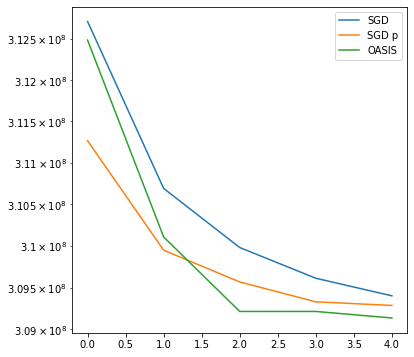

In [261]:
plt.semilogy(loss_rec)
plt.semilogy(loss_p_rec)
plt.semilogy(loss_o)

plt.legend(["SGD", "SGD p", "OASIS"])
#plt.legend(["SGD", "OASIS"])

In [262]:
jnp.max(jnp.abs(v_rec))

DeviceArray(6072.79458077, dtype=float64)

In [263]:
jnp.max(jnp.abs(v_rec_o))

DeviceArray(7788.97577997, dtype=float64)

In [264]:
vv = v_rec_o.at[jnp.abs(v_rec_o) > jnp.max(jnp.abs(v_rec))].set(0)

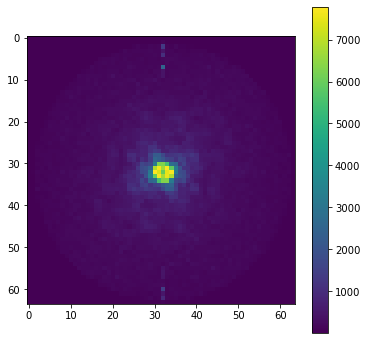

In [265]:
mip_z(np.fft.fftshift(np.abs(v_rec_o))); plt.colorbar()
#mip_z(np.fft.fftshift(np.abs(vv))); plt.colorbar()

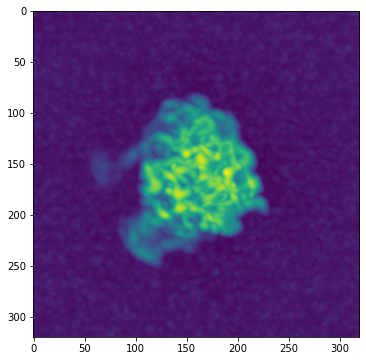

In [266]:
v_rec_ol, _ = rescale_larger_grid(v_rec_o, x_grid, nx0)
vr_o = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_rec_ol)))

mip_z(vr_o)
#plt.colorbar()

In [267]:
with mrcfile.new(f"{out_dir}/v_rec_o.mrc", overwrite=True) as mrc:
    mrc.set_data(vr_o.astype(np.float32))

In [268]:
#res, fsc_o, shell_points = calc_fsc(v_rec_o1, v_rec_o2, [1, nx_crop])
#res, fsc_o, shell_points = calc_fsc(vv1, vv2, [1, nx_crop])
#
#res_angs = nx0 * pixel_size[0]/res
#plt.semilogx(res_angs, fsc_o)
#plt.gca().invert_xaxis()
#plt.title("FSC")

In [255]:
# Just make sure that the loss at the starting points x01 and x02 is indeed larger than
# everything plotted

batch_sz = 100
n_batch = N / batch_sz
idx_batches = np.array_split(np.arange(N), n_batch)

loss_x0 = 0
for idx in tqdm(idx_batches):
    loss_x0 += loss_func(x0, idx)
    
loss_x0 = loss_x0/n_batch                             

print(f"loss(x0) = {loss_x0}")

100%|██████████| 100/100 [00:08<00:00, 11.90it/s]

loss(x0) = 328674692.25904405


#### CG

In [274]:
N_iter = 5


In [275]:
AA, Ab = get_cg_vol_ops(gradv_obj.grad_loss_volume_sum, angles, shifts, ctf_params, imgs_f, v_rec.shape, sigma_noise)


In [276]:
v_rec_cg, k, v_rec_cg_all = cg(AA, Ab, x0, N_iter, verbose=True)

  cg iter 0 ||r|| = 292.95455735876016


In [277]:
loss_cg = jax.vmap(loss_func, in_axes = (0, None))(jnp.array(v_rec_cg_all), jnp.arange(N))

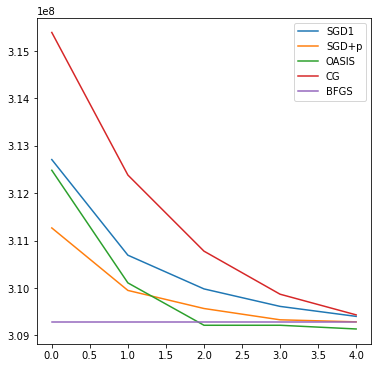

In [286]:
plt.plot(loss_rec)
plt.plot(loss_p_rec)
plt.plot(loss_o)
plt.plot(loss_cg)

plt.plot(loss_bfgs*jnp.ones(loss_rec.shape))


plt.legend(["SGD1", "SGD+p", "OASIS", "CG", "BFGS"])


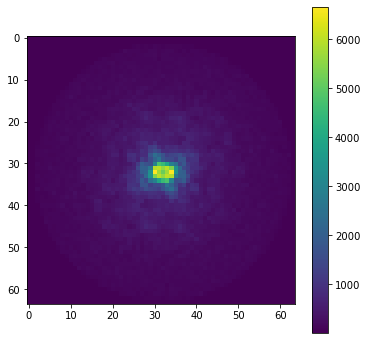

In [290]:
mip_z(np.fft.fftshift(np.abs(v_rec_cg))); plt.colorbar()

In [ ]:
v_rec_cgl1, _ = rescale_larger_grid(v_rec_cg1, x_grid, nx0)
vr_cg1 = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_rec_cgl1)))

v_rec_cgl2, _ = rescale_larger_grid(v_rec_cg2, x_grid, nx0)
vr_cg2 = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_rec_cgl2)))

plt.subplot(1,2,1)
mip_z(vr_cg1)
#plt.colorbar()

plt.subplot(1,2,2)
mip_z(vr_cg2)
#plt.colorbar()

plt.rcParams["figure.figsize"]=6, 6


In [ ]:
with mrcfile.new(f"{out_dir}/v_rec_cg1.mrc", overwrite=True) as mrc:
    mrc.set_data(vr_cg1.astype(np.float32))
    
with mrcfile.new(f"{out_dir}/v_rec_cg2.mrc", overwrite=True) as mrc:
    mrc.set_data(vr_cg2.astype(np.float32))  

In [ ]:
res, fsc_cg, shell_points = calc_fsc(v_rec_cg1, v_rec_cg2, [1, nx_crop])

res_angs = nx0 * pixel_size[0]/res
plt.semilogx(res_angs, fsc_cg)
plt.gca().invert_xaxis()
plt.title("FSC")

In [ ]:
fsc_cg

In [ ]:
loss1_x0 = loss_func1(x01, jnp.arange(N)) * jnp.ones((N_iter,))
loss2_x0 = loss_func2(x02, jnp.arange(N)) * jnp.ones((N_iter,))

In [ ]:
plt.rcParams["figure.figsize"]=12,6

plt.subplot(1,2,1)

plt.plot(loss_rec1, 'r')
plt.plot(loss_rec2, 'g')
plt.plot(loss_o1, 'r--')
plt.plot(loss_o2, 'g--')
plt.plot(loss_cg1, 'r:')
plt.plot(loss_cg2, 'g:')
#plt.semilogy(loss1_x0)
#plt.semilogy(loss2_x0)

plt.title("Loss")
plt.legend(["SGD1", "SGD2", "OASIS1", "OASIS2", "CG1", "CG2"])

plt.subplot(1,2,2)

plt.semilogx(res_angs, fsc_sgd)
plt.semilogx(res_angs, fsc_o)
plt.semilogx(res_angs, fsc_cg)
plt.gca().invert_xaxis()
plt.title("FSC")
plt.legend(["SGD", "OASIS", "CG"])

plt.rcParams["figure.figsize"]=6,6

In [ ]:
print(fsc_cg[15])
print(fsc_cg[16])
print(res_angs[15])
print(res_angs[16])

In [ ]:
print(loss_func1(v_rec1, jnp.arange(N)))
print(loss_func1(v_p_rec1, jnp.arange(N)))
print(loss_func1(v_rec_o1, jnp.arange(N)))
print(loss_func1(v_rec_cg1, jnp.arange(N)))

In [ ]:
print(loss_func2(v_rec2, jnp.arange(N)))
print(loss_func2(v_p_rec2, jnp.arange(N)))
print(loss_func2(v_rec_o2, jnp.arange(N)))
print(loss_func2(v_rec_cg2, jnp.arange(N)))

### Notes:

* It's important to use a large batch size for both SGD and OASIS: 1000 for 64-128px is good.
* OASIS rec with fixed rate is the same as SGD with D0 preconditioner,  the loss and results/FSC are almost identical (since here the Hessian doesn't depend on the current iterate and therefore is estimated perfectly at the beginning). -- actually not true in my latest experiments and I don't know why
* When using no $\sigma_{noise}$ with $128$ pixels and 40,000 images, both OASIS and SGD with precon required higher regularization parameter $10^{-5}$ compared to the other runs, where I used reg param $10^{-9}$
* I should with a dataset with no heterogeneity in the future
* Still don't know why the adaptive version fails

In [ ]:
pixel_size * 320/128

### Results:

Showing resolution cutoff at $FSC=0.5$ everywhere:

#### 1. Small data: `nx_crop=64px` and 10,000 images in each half set, 20 epochs (for SGD/OASIS) and 20 iters (for CG):

Everything here is with regularization parameter $10^{-9}$

Trilinear interpolation
* SGD no precon: $\approx 20 Å$ 
* SGD with precon: $\approx 20 Å$ 
* OASIS: $\approx 20 Å$ 
* OASIS adaptive: meh
* CG: $\approx 20 Å$ 

Nearest neighbour interpolation:

All $\approx 20 Å$ 


^ The FSC curves are almost identical for all

#### 2. Large data: `nx_crop=128px` and 40,000 images in each half set, 10 epochs:

Tri and NN, all around $\approx 14-15 Å$ 

# Figuring out the algorithm, running it on toy problem

### OASIS

#### Hutchinson's method

The diagonal of a symmetric matrix can be approximated as follows:

$
\text{diag}(A) = \mathbb{E}[z * Az ],
$

where $z$ is a random vector with Rademacher or Gaussian distribution and $*$ represents element-wise multiplication.

Here we're reproducing Figure 1 in the OASIS paper.

In [ ]:
n = 100

key = random.PRNGKey(int(jnp.floor(np.random.rand()*1000)))

In [ ]:
key, subkey = random.split(key)

A = random.normal(subkey, (n,n), dtype=jnp.complex128)
A = A.T + A

plt.imshow(jnp.real(A)); plt.colorbar()

In [ ]:
iters = 10000

key, subkey = random.split(key)
z = random.rademacher(subkey, (iters, n))

#z * A @ z 

In [ ]:
zAz = jax.vmap(lambda zi : zi * (A @ zi))(z)
#plt.imshow(zAz)

In [ ]:
d = np.zeros((iters, n), dtype=A.dtype)
d[0] = zAz[0]
for i in range(1, iters):
    d[i] = d[i-1] + zAz[i]
    
for i in range(1, iters):
    d[i] = d[i]/(i+1)

In [ ]:
err = jnp.mean((d - jnp.diag(A))**2, axis=1)

In [ ]:
plt.semilogy(jnp.abs(err))

#### Hessian-vector product in JaX

In [ ]:
key, *subkey = random.split(key, 4)
x0 = random.normal(subkey[0], (n,))
x = random.normal(subkey[1], (n,))
v = random.normal(subkey[2], (n,))

In [ ]:
b = A @ x0 
f = lambda x : jnp.real(jnp.mean(jnp.conj(A @ x - b)*(A@x-b)))

In [ ]:
from jax import jvp, grad

# Naive
def hvp0(f, x, v):
    return grad(lambda x : jnp.vdot(grad(f)(x), v))(x)

# forward-over-reverse
def hvp(f, x, v):
    return jvp(jax.grad(f), x, v)[1]

In [ ]:
%timeit hvp0(f, x, v)

%timeit hvp(f, (x,), (v,))

v1 = hvp0(f, x, v)
v2 = hvp(f, (x,), (v,))
jnp.sum(jnp.abs(v1-v2))

#### Toy problem

In [ ]:
key, *subkey = random.split(key, 3)

x_gt = random.normal(subkey[0], (n,), dtype=jnp.complex128)

A = random.normal(subkey[1], (n,n), dtype=x_gt.dtype)
A = A.T @ A
_, v = jnp.linalg.eigh(A)
d = jnp.flip(jnp.logspace(-5,1,n)) 
d = d + jnp.abs(jnp.min(d)*2)
A = v.T @ jnp.diag(d) @ v

evals, evecs = np.linalg.eig(A)
evals = np.flip(np.sort(evals))


assert(jnp.sum(evals < 0) == 0)
assert(jnp.max(jnp.imag(evals)) < 1e-13)
#assert(jnp.max(jnp.abs(A.T - A)) == 0)
#assert(jnp.sum(jnp.abs(A@A.T - A.T@ A)) == 0)

evals = jnp.real(evals)
plt.semilogy(evals, '.')
plt.title("Eigenvalues")
print(f"Condition number = {evals[0]/evals[n-1] : .2e}")

In [ ]:
sig_noise = 1
lam = 0.1

key, subkey = random.split(key)

b = A @ x_gt  + random.normal(subkey, (n,)) * sig_noise

F = jax.jit(lambda x : jnp.real(jnp.mean(jnp.conj(A @ x - b)*(A @ x - b)) + lam * jnp.mean(jnp.conj(x)*x)))
print(f"f(x_gt + 1) = {F(x_gt+1)}")
print(f"f(x_gt) = {F(x_gt)}")

gradF = jax.jit(jax.grad(F))
#hessianF = jax.hessian(F)

hvpF = jax.jit(lambda x, v : hvp(F, (x,), (v,)))

print(f"gradF(x_gt) = {gradF(x_gt)}")
#print(f"hessianF(x_gt) = {hessianF(x_gt)}")


In [ ]:
def gd(F, gradF, eta, w0, N_iter = 20, iter_display = 1):
    loss = []
    for k in range(1, N_iter+1):
        w1 = w0 - eta * jnp.conj(gradF(w0))
        loss_i = F(w1)
        loss.append(loss_i)
        
        w0 = w1
        
        if k % iter_display == 0:
            print(f"Iter {k}: loss = {loss_i}")
            
    return w1, jnp.array(loss)

def newton(F, gradF, hessianF, w0, N_iter = 20, iter_display = 1):
    loss = []
    for k in range(1, N_iter+1):
        G = gradF(w0)
        H = hessianF(w0)
        
        w1 = w0 - jnp.conj(jnp.linalg.inv(H) @ G)
        loss_i = F(w1)
        loss.append(loss_i)
        
        w0 = w1
        
        if k % iter_display == 0:
            print(f"Iter {k}: loss = {loss_i}")
            
    return w1, jnp.array(loss)

In [ ]:
N_iter = 1000
eta = 1e-3 #0.000005 # learning rate
x0 = np.random.randn(*x_gt.shape)

x_gd, loss_gd = gd(F, gradF, eta, x0, N_iter, iter_display = 200)

In [ ]:
plt.semilogy(loss_gd)

In [ ]:
#N_iter = 10

#x_n, loss_n = newton(F, gradF, hessianF, x0, N_iter, iter_display = 1)

In [ ]:
#plt.plot(loss_n)

In [ ]:
N_iter = 1000

zero = jnp.zeros(x_gt.shape)
Abfun = gradF(zero)

Ab = -jnp.conj(Abfun)
AA = jax.jit(lambda vv : jnp.conj(gradF(vv)) + Ab)

x_cg, kk, x_cg_all = cg(AA, Ab, x0, N_iter, verbose=True)
loss_cg = jax.vmap(F)(jnp.array(x_cg_all))

In [ ]:
print(F(x_gt))
print(F(x_cg))
print(F(x_gd))
#print(F(x_n))

#### OASIS

In [ ]:
Fidx = jax.jit(lambda x, idx : F(x))
gradFidx = jax.jit(lambda x, idx : jax.grad(F)(x))
hvpFidx = jax.jit(lambda x, v, idx : hvp(F, (x,), (v,)))

In [ ]:
# Estimating D0

iters = 100000
key, *subkeys = random.split(key, iters+1)
zD0z = np.zeros((n,))

for i in tqdm(range(iters)):
    z = random.rademacher(subkeys[i], (n,), dtype=x0.dtype)
    
    zD0z += z * hvpFidx(x0, z, 1)
    
D0 = jnp.array(zD0z/iters)

#D0exact = jnp.diag(hessianF(x0)) # Cheating a bit


In [ ]:
#plt.plot(jnp.abs(D0-D0exact)/jnp.abs(D0exact))

In [ ]:
N_iter = 1000
beta2 = 0.99
eta = 0.1 #0.1 #0.1/0.001/0.01/0.15
                       
alpha = 0.1 #0.1 # 0.01

key, subkey = random.split(key)
x_o, loss_o = oasis(subkey, Fidx, gradFidx, hvpFidx, x0, eta, D0, beta2, alpha, N_iter, iter_display = 100)


In [ ]:
N_iter = 1000
beta2 = 0.99
eta0 = 0.1 #0.1/0.001/0.01/0.15
                       
alpha = 0.1 # 0.01

key, subkey = random.split(key)
x_oa, loss_oa = oasis_adaptive(subkey, Fidx, gradFidx, hvpFidx, x0, eta0, D0, beta2, alpha, N_iter, iter_display = 500)


In [ ]:
#print(jnp.mean(jnp.abs(x_gt-x_n)))
print(jnp.mean(jnp.abs(x_gt-x_cg)))
print(jnp.mean(jnp.abs(x_gt-x_gd)))
print(jnp.mean(jnp.abs(x_gt-x_o)))
print(jnp.mean(jnp.abs(x_gt-x_oa)))

plt.rcParams["figure.figsize"]=12, 6

plt.subplot(1,2,1)

nn0 = 0
nn1 = 1000
#plt.semilogy(loss_n[nn0:nn1])
plt.semilogy(loss_gd[nn0:nn1])
plt.semilogy(loss_cg[nn0:nn1])
plt.semilogy(loss_o[nn0:nn1])
plt.semilogy(loss_oa[nn0:nn1])
#plt.legend(["Newton", "GD", "OASIS", "OASIS adaptive"])
plt.legend(["GD", "CG", "OASIS", "OASIS adaptive"])
plt.title("Loss")

plt.subplot(1,2,2)
#plt.semilogy(jnp.abs(x_gt-x_n))
plt.semilogy(jnp.abs(x_gt-x_gd))
plt.semilogy(jnp.abs(x_gt-x_o))
plt.semilogy(jnp.abs(x_gt-x_oa))
plt.legend(["GD", "OASIS", "OASIS_adaptive"])
plt.title("Error")

plt.rcParams["figure.figsize"]=6, 6

### Stochastic - sum of operators

In [ ]:
key = random.PRNGKey(int(jnp.floor(np.random.rand()*1000)))

Generate $N$ operators to create a loss function to run SGD/OASIS on:

In [ ]:
sig_noise = 10
lam = 0.1

In [ ]:
n = 100
N = 1000

key, subkey = random.split(key)

x_gt = random.normal(subkey, (n,), dtype=jnp.complex128)

ops = []
b = []
for i in range(N):
    key, *subkeys = random.split(key, 4)
    
    A = random.normal(subkeys[0], (n,n), dtype = x_gt.dtype)
    A = A.T @ A
    _, v = jnp.linalg.eigh(A)
    
    d = jnp.logspace(10,-5,n) + random.normal(subkeys[1], (n,), dtype = jnp.double)*10 
    d = d + jnp.abs(jnp.min(d)*2)
                 
    A = v.T @ jnp.diag(d) @ v
    ops.append(A)
    
    bn = A @ x_gt + random.normal(subkeys[2], (n,), dtype = x_gt.dtype) * sig_noise
    b.append(bn)
    
    #print(jnp.mean((A@x_gt - bn)**2))
    
ops = jnp.array(ops)
b = jnp.array(b)

In [ ]:
w, _ = jnp.linalg.eigh(A)
w = jnp.flip(jnp.sort(w))
print(f"{jnp.max(w)/jnp.min(w) : .2e}")

In [ ]:
print(jnp.max(w))
print(jnp.min(w))

In [ ]:
def loss_term(x, A, b):
    return 1/2 * jnp.real(jnp.mean(jnp.conj(A@x - b)*(A@x - b)) + lam * jnp.mean(jnp.conj(x)*x))

def loss_func(x, ops, b):
    return jnp.mean(jax.vmap(loss_term, in_axes = (None, 0, 0))(x, ops, b))

def grad_loss_func(x, ops, b):
    return jax.grad(loss_func)(x, ops, b)

def hvp_loss_func(x, v, ops, b):
    return jvp(lambda y : grad_loss_func(y, ops, b), (x,), (v,))[1]

In [ ]:
idx = np.random.permutation(N)[:N//3]

print(loss_term(x_gt, ops[0], b[0]))
print(loss_func(x_gt, ops, b))

print(grad_loss_func(x_gt, ops, b).shape)
print(grad_loss_func(x_gt, ops[idx], b[idx]).shape)

print(hvp_loss_func(x_gt, x_gt, ops, b).shape)
print(hvp_loss_func(x_gt, x_gt, ops[idx], b[idx]).shape)

In [ ]:
key, subkey = random.split(key)

hessianF = lambda x : jax.hessian(loss_func)(x, ops, b)

Fidx = jax.jit(lambda x, idx : loss_func(x, ops[idx], b[idx]))
gradFidx = jax.jit(lambda x, idx : grad_loss_func(x, ops[idx], b[idx]))
hvpFidx = jax.jit(lambda x, v, idx : hvp_loss_func(x, v, ops[idx], b[idx]))
x0 = random.normal(subkey, (n,), dtype = x_gt.dtype)

In [ ]:
Fidx(x_gt, jnp.arange(N))

In [ ]:
#D0 = jnp.ones((nx,nx,nx))  #<--- not very good
#D0exact = jnp.diag(hessianF(x0)) # This is cheating

iters = 10000
batch_sz = 32
key, *subkeys = random.split(key, 2*iters+1)

zD0z = np.zeros((n,))

for i in tqdm(range(iters)):
    z = random.rademacher(subkeys[2*i], (n,), dtype=x0.dtype)
    idx = random.permutation(subkeys[2*i+1], N)[:batch_sz]
    
    zD0z += z * hvpFidx(x0, z, idx)
    
D0 = jnp.array(zD0z/iters)


#plt.plot(jnp.abs(D0-D0exact)/jnp.abs(D0exact))

In [ ]:
N_epoch = 20
beta2 = 0.99
eta = 1e-1 #0.1 #0.1/0.001/0.01/0.15
                       
alpha = 0 #0.1 #0.1 # 0.01

key, subkey = random.split(key)
x_os, loss_os = oasis(subkey, Fidx, gradFidx, hvpFidx, x0, eta, D0, beta2, alpha, N_epoch, batch_size = 20, N = N, iter_display = 1)


In [ ]:
N_epoch = 20
beta2 = 0.99
eta = 0.01 #0.1 #0.1/0.001/0.01/0.15
                       
alpha = 0 #0.1 #0.1 # 0.01

key, subkey = random.split(key)
x_osa, loss_osa = oasis_adaptive(subkey, Fidx, gradFidx, hvpFidx, x0, eta, D0, beta2, alpha, N_epoch, batch_size = 20, N = N, iter_display = 1)


In [ ]:
N_epoch = 20
beta2 = 0.99
eta = 1e-1 #0.1 #0.1/0.001/0.01/0.15
                       
alpha = 0 #0.1 #0.1 # 0.01

key, subkey = random.split(key)
x_o, loss_o = oasis(subkey, Fidx, gradFidx, hvpFidx, x0, eta, D0, beta2, alpha, N_epoch, batch_size = None, N=N, iter_display = 1)

In [ ]:
N_epoch = 20
beta2 = 0.99
eta = 1e-1 #0.1 #0.1/0.001/0.01/0.15
                       
alpha = 0 #0.1 #0.1 # 0.01

key, subkey = random.split(key)
x_oa, loss_oa = oasis_adaptive(subkey, Fidx, gradFidx, hvpFidx, x0, eta, D0, beta2, alpha, N_epoch, batch_size = None, N=N, iter_display = 1)


In [ ]:
N_epoch = 20
eta = 1e-18
                       
key, subkey = random.split(key)
x_sgd, loss_sgd, _ = sgd(gradFidx, Fidx, N, x0, eta, N_epoch, batch_size = 20, verbose = True, iter_display = 1)

In [ ]:
N_epoch = 20
beta2 = 0.99
eta = 1e-1
                       
key, subkey = random.split(key)
x_sgdp, loss_sgdp, _ = sgd(gradFidx, Fidx, N, x0, eta, N_epoch, batch_size = 20, P = 1/D0, verbose = True, iter_display = 1)

In [ ]:
plt.rcParams["figure.figsize"]=12, 6

plt.subplot(1,2,1)
plt.semilogy(loss_sgd)
plt.semilogy(loss_sgdp)
plt.semilogy(loss_o)
plt.semilogy(loss_os)
plt.semilogy(loss_oa)
plt.semilogy(loss_osa)
plt.legend(["SGD", "SGD precon", "OASIS fixed rate, deterministic", "OASIS fixed_rate, stochastic", "OASIS adaptive, deterministic", "OASIS adaptive, stochastic"])
#plt.legend(["SGD", "OASIS fixed_rate, stochastic", "OASIS adaptive, stochastic"])
plt.title("Loss")

plt.subplot(1,2,2)
plt.semilogy(jnp.abs(x_sgd-x_gt))
plt.semilogy(jnp.abs(x_sgdp-x_gt))
#plt.semilogy(jnp.abs(x_o-x_gt))
plt.semilogy(jnp.abs(x_os-x_gt))
#plt.semilogy(jnp.abs(x_oa-x_gt))
plt.semilogy(jnp.abs(x_osa-x_gt))
#plt.legend(["SGD", "OASIS fixed rate, deterministic", "OASIS fixed_rate, stochastic", "OASIS adaptive, deterministic", "OASIS adaptive, stochastic"])
plt.legend(["SGD", "SGD+p", "OASIS fixed_rate, stochastic", "OASIS adaptive, stochastic"])
plt.title("Error")

plt.rcParams["figure.figsize"]=6,6

In [ ]:
plt.semilogy(loss_sgdp)
plt.semilogy(loss_os)
plt.legend(["Loss SGD+precon", "Loss OASIS stochastic"])

In [ ]:
print(Fidx(x_gt, jnp.arange(N)))
print(Fidx(x_sgd, jnp.arange(N)))
print(Fidx(x_sgdp, jnp.arange(N)))
print(Fidx(x_o, jnp.arange(N)))
print(Fidx(x_os, jnp.arange(N)))
print(Fidx(x_oa, jnp.arange(N)))
print(Fidx(x_osa, jnp.arange(N)))


Next:

* ~~Run the new OASIS algorithms on the old (deterministic one operator) toy problem~~
* ~~Implement the adaptive version of the stochastic OASIS~~
* ~~Add noise and rerun all the experiments~~
* In the stochastic toy problem case, also compare with CG (make the problem small enough so that we can do CG)
* ~~Implement some kind of warm up /estimation of $D_0$~~
* ~~Run on CryoEM data~~